# INF-510, v0.31, Claudio Torres, ctorres@inf.utfsm.cl. DI-UTFSM
## Textbook: Lloyd N. Trefethen, Spectral Methods in MATLAB, SIAM, Philadelphia, 2000

# More on Spectral Matrices

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.sparse.linalg as sp
from scipy import interpolate
import scipy as spf
from sympy import *
import sympy as sym
from scipy.linalg import toeplitz
from ipywidgets import interact
from ipywidgets import IntSlider
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
# The variable M is used for changing the default size of the figures
M=5
import ipywidgets as widgets
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
sym.init_printing()

### Chebyshev differentiation matrix

In [6]:
def cheb(N):
    if N==0:
        D=0
        x=1
        return D,x
    x = np.cos(np.pi*np.arange(N+1)/N)
    c=np.hstack((2,np.ones(N-1),2))*((-1.)**np.arange(N+1))
    X=np.tile(x,(N+1,1)).T
    dX=X-X.T
    D = np.outer(c,1./c)/(dX+np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    return D,x

## Understanding how the np.FFT does the FFT

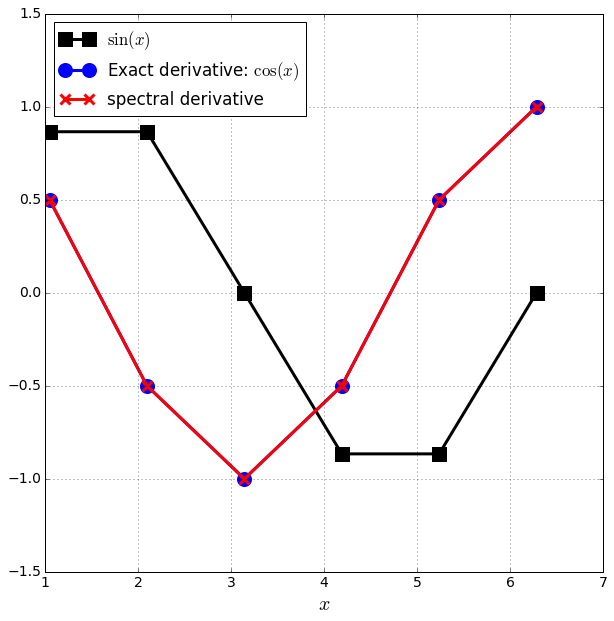

v    : [  8.66025404e-01   8.66025404e-01   1.22464680e-16  -8.66025404e-01
  -8.66025404e-01  -2.44929360e-16]
vhat : [ -3.44509285e-16 +0.00000000e+00j   2.59807621e+00 -1.50000000e+00j
  -1.60812265e-16 -1.06057524e-16j   0.00000000e+00 +5.55111512e-16j
  -1.60812265e-16 +1.06057524e-16j   2.59807621e+00 +1.50000000e+00j]
K    : [ 0.  1.  2. -3. -2. -1.]
W    : [ -0.00000000e+00 +0.00000000e+00j   1.50000000e+00 +2.59807621e+00j
   2.12115048e-16 -3.21624530e-16j   0.00000000e+00 +0.00000000e+00j
   2.12115048e-16 +3.21624530e-16j   1.50000000e+00 -2.59807621e+00j]
vprime:  [ 0.5 -0.5 -1.  -0.5  0.5  1. ]


In [9]:
def show_spectral_derivative_example(N):
    x=np.linspace(2*np.pi/N,2*np.pi,N)
    u = lambda x: np.sin(x)
    up = lambda x: np.cos(x)
    
    #u = lambda x: np.sin(x)*np.cos(x)
    #up = lambda x: np.cos(x)*np.cos(x)-np.sin(x)*np.sin(x)
    
    v=u(x)
    K=np.fft.fftfreq(N)*N
    iK=1j*K
    vhat=np.fft.fft(v)
    
    W=iK*vhat
    W[int(N/2)]=0

    vp=np.real(np.fft.ifft(W))

    plt.figure(figsize=(10,10))
    plt.plot(x,v,'ks-',markersize=12,markeredgewidth=3,label='$\sin(x)$',linewidth=3)
    plt.plot(x,up(x),'b.-',markersize=24,markeredgewidth=3,label='Exact derivative: $\cos(x)$',linewidth=3)
    plt.plot(x,np.real(vp),'rx-',markersize=10,markeredgewidth=3,label='spectral derivative',linewidth=3)
    plt.grid(True)
    plt.legend(loc='best')
    plt.xlabel('$x$')
    plt.show()
    
    print('v    :',v)
    print('vhat :',vhat)
    print('K    :',K)
    print('W    :',W)
    print('vprime: ',vp)
widgets.interact(show_spectral_derivative_example,N=(2,40,2))

In [10]:
def spectralDerivativeByFFT(v,nu=1):
    if not np.all(np.isreal(v)):
        raise ValueError('The input vector must be real')
    N=v.shape[0]
    K=np.fft.fftfreq(N)*N
    iK=(1j*K)**nu
    v_hat=np.fft.fft(v)
    w_hat=iK*v_hat
    if np.mod(nu,2)!=0:
        w_hat[int(N/2)]=0
    return np.real(np.fft.ifft(w_hat))

def my_D2_spec_2pi(N):
    h=(2*np.pi/N)
    c=np.zeros(N)
    j=np.arange(1,N)
    c[0]=-np.pi**2/(3.*h**2)-1./6.
    c[1:]=-0.5*((-1)**j)/(np.sin(j*h/2.)**2)
    D2=toeplitz(c)
    return D2

# Fractional derivative application

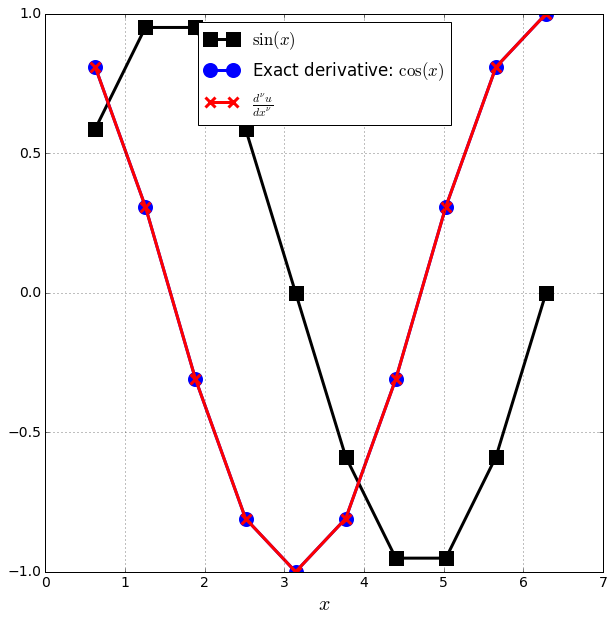

<function __main__.fractional_derivative>

In [22]:
def fractional_derivative(N=10,nu=1):
    x=np.linspace(2*np.pi/N,2*np.pi,N)
    u = lambda x: np.sin(x)
    up = lambda x: np.cos(x)
    v = u(x)
    vp=spectralDerivativeByFFT(v,nu)
    plt.figure(figsize=(10,10))
    plt.plot(x,v,'ks-',markersize=12,markeredgewidth=3,label='$\sin(x)$',linewidth=3)
    plt.plot(x,up(x),'b.-',markersize=24,markeredgewidth=3,label='Exact derivative: $\cos(x)$',linewidth=3)
    plt.plot(x,np.real(vp),'rx-',markersize=10,markeredgewidth=3,label=r'$\frac{d^{\nu}u}{dx^{\nu}}$',linewidth=3)
    plt.grid(True)
    plt.legend(loc='best')
    plt.xlabel('$x$')
    plt.show()
d_nu=0.1
widgets.interact(fractional_derivative,N=(4,100),nu=(d_nu,1,d_nu))

# Example 1: Computing Eigenvalues

We are solving: $-u''(x)+x^2\,u(x)=\lambda\, u(x)$ on $\mathbb{R}$

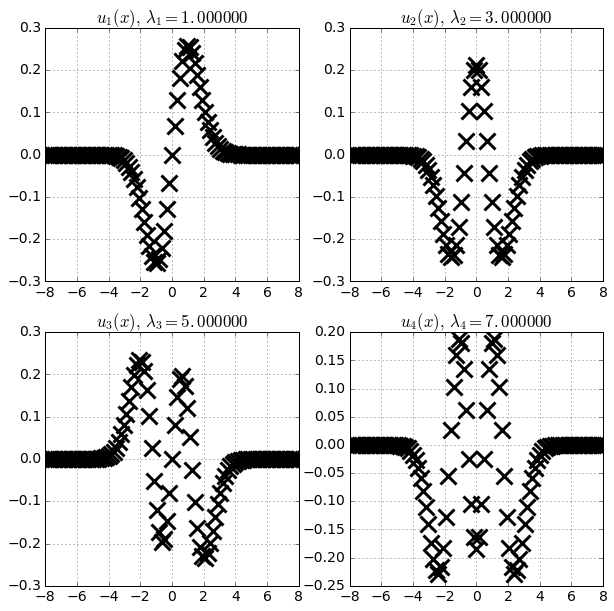

In [23]:
L=8.0
def show_example_1(N=6):
    h=2*np.pi/N
    x=np.linspace(h,2*np.pi,N)
    x=L*(x-np.pi)/np.pi
    D2=(np.pi/L)**2*my_D2_spec_2pi(N)
    w, v = np.linalg.eig(-D2+np.diag(x**2))
    # eigenvalues = np.sort(np.linalg.eigvals(-D2+np.diag(x**2)))
    ii = np.argsort(w)
    w=w[ii]
    v=v[:,ii]
    
    plt.figure(figsize=(2*M,2*M))

    for i in np.arange(1,5):
        plt.subplot(2,2,i)
        plt.title(r'$u_{:d}(x),\, \lambda_{:d}={:f}$'.format(i,i,w[i-1]))
        plt.plot(x,v[:,i],'kx',markersize=16,markeredgewidth=3)
        plt.grid(True)
    plt.show()
widgets.interact(show_example_1,N=(6,100,1))

# Example 2:  Solving ODE

Solving the following BVP $u_{xx}=\exp(4\,x)$ with $u(-1)=u(1)=0$

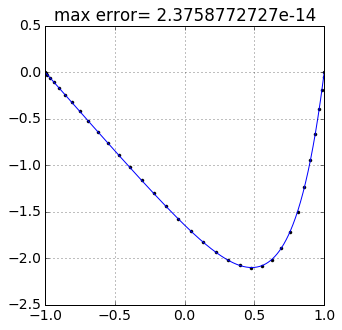

In [24]:
def example_2(N=16):
    D,x = cheb(N)
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]
    f   = np.exp(4*x[1:-1])
    u   = np.linalg.solve(D2,f)
    u   = np.concatenate(([0],u,[0]),axis=0)

    plt.figure(figsize=(M,M))
    plt.plot(x,u,'k.')
    xx  = np.linspace(-1,1,1000)
    P   = np.polyfit(x, u, N)
    uu  = np.polyval(P, xx)
    plt.plot(xx,uu,'b-')
    plt.grid(True)
    exact = (np.exp(4*xx)-np.sinh(4.)*xx-np.cosh(4.))/16.
    plt.title('max error= '+str(np.linalg.norm(exact-uu,np.inf)))
    plt.ylim([-2.5,0.5])
    plt.show()
interact(example_2,N=(2,35))

# Example 3: Solving ODE 

Solving the following BVP $u_{xx}=\exp(u)$ with $u(-1)=u(1)=0$

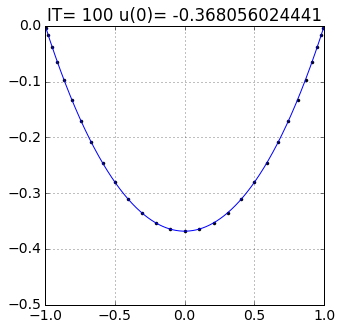

In [25]:
def example_3(N=16,IT=20):
    D,x = cheb(N)
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    u   = np.zeros(N-1)
    for i in np.arange(IT):
        u_new = np.linalg.solve(D2,np.exp(u))
        change = np.linalg.norm(u_new-u,np.inf)
        u = u_new

    u = np.concatenate(([0],u,[0]),axis=0)

    plt.figure(figsize=(M,M))
    plt.plot(x,u,'k.')
    xx  = np.linspace(-1,1,1000)
    P   = np.polyfit(x, u, N)
    uu  = np.polyval(P, xx)
    plt.plot(xx,uu,'b-')
    plt.grid(True)
    plt.title('IT= '+str(IT)+' u(0)= '+str(u[int(N/2)]))
    plt.ylim([-0.5,0.])
    plt.show()

interact(example_3,N=(2,30),IT=(0,100))

# Example 4: Eigenvalue BVP

Solve $u_{xx}=\lambda\,u$ with $u(-1)=u(1)=0$

/Users/claudio/anaconda/lib/python3.4/site-packages/numpy/lib/polynomial.py:594: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


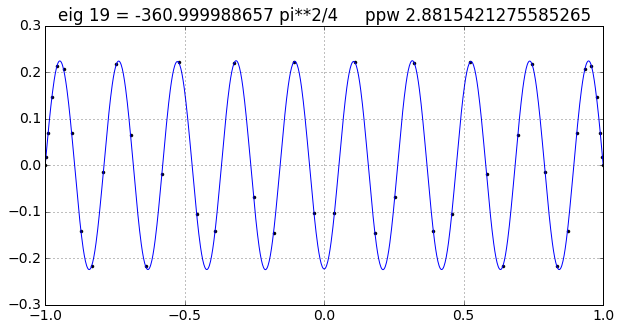

In [26]:
N_widget = IntSlider(min=2, max=50, step=1, value=10)
j_widget = IntSlider(min=1, max=49, step=1, value=5)

def update_j_range(*args):
    j_widget.max = N_widget.value-1
j_widget.observe(update_j_range, 'value')

def example_4(N=36,j=5):
    D,x = cheb(N)
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    lam, V = np.linalg.eig(D2)

    ii=np.argsort(-np.real(lam))

    lam=lam[ii]
    V=V[:,ii]

    u = np.concatenate(([0],V[:,j-1],[0]),axis=0)

    plt.figure(figsize=(2*M,M))
    plt.plot(x,u,'k.')
    xx  = np.linspace(-1,1,1000)
    P   = np.polyfit(x, u, N)
    uu  = np.polyval(P, xx)
    plt.plot(xx,uu,'b-')
    plt.grid(True)
    plt.title('eig '+str(j)+' = '+str(lam[j-1]*4./(np.pi**2))+' pi**2/4'+'     ppw '+str(4*N/(np.pi*j)))
    plt.show()
interact(example_4,N=N_widget,j=j_widget)

# Example 5:  (2D) Poisson equation $u_{xx}+u_{yy}=f$ with u=0 on $\partial\Gamma$

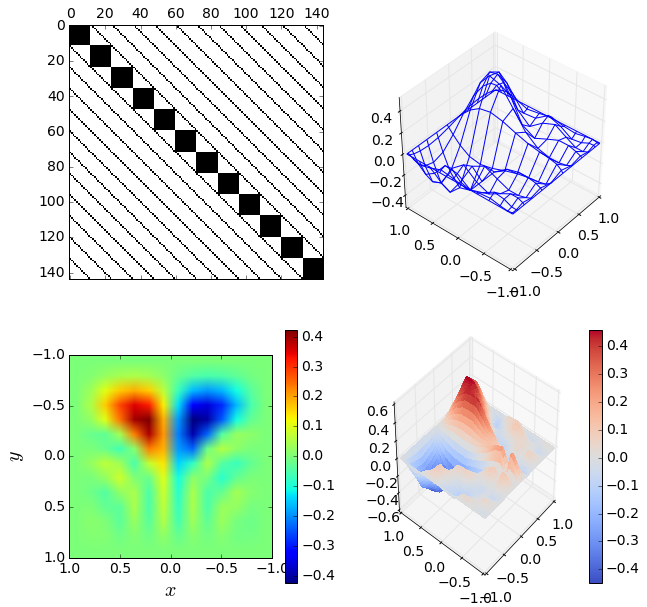

In [28]:
elev_widget = IntSlider(min=0, max=180, step=10, value=40)
azim_widget = IntSlider(min=0, max=360, step=10, value=230)

def example_5(N=10,elev=40,azim=230):
    D,x = cheb(N)
    y=x
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    xx,yy=np.meshgrid(x[1:-1],y[1:-1])
    xx = xx.flatten()
    yy = yy.flatten()

    f = 10*np.sin(8*xx*(yy-1))

    I = np.eye(N-1)
    # The Laplacian
    L = np.kron(I,D2)+np.kron(D2,I)

    u = np.linalg.solve(L,f)

    fig = plt.figure(figsize=(2*M,2*M))

    # The spy of the Laplacian
    plt.subplot(221)
    plt.spy(L)

    # Plotting the approximation and its interpolation

    # The numerical approximation
    uu = np.zeros((N+1,N+1))
    uu[1:-1,1:-1]=np.reshape(u,(N-1,N-1))
    xx,yy=np.meshgrid(x,y)
    value = uu[int(N/4),int(N/4)]

    plt.subplot(222,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xx, yy, uu)
    ax.view_init(elev,azim)

    # The INTERPOLATED approximation

    N_fine=4*N
    finer_mesh=np.linspace(-1,1,N_fine)
    xxx,yyy=np.meshgrid(finer_mesh,finer_mesh)
    uuu = spf.interpolate.interp2d(xx, yy, uu, kind='linear')
    uuu_n=np.reshape(uuu(finer_mesh,finer_mesh),(N_fine,N_fine))

    plt.subplot(224,projection='3d')
    ax = fig.gca()
    surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    #ax.plot_wireframe(xxx, yyy, uuu_n)
    fig.colorbar(surf)
    ax.view_init(elev,azim)
    
    plt.subplot(223)
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    extent = [x[0], x[-1], y[0], y[-1]]
    plt.imshow(uu, extent=extent)
    plt.ylabel('$y$')
    plt.xlabel('$x$')
    plt.colorbar()
    
    plt.show()
interact(example_5,N=(3,20),elev=elev_widget,azim=azim_widget)

# Example 6:  (2D) Helmholtz equation $u_{xx}+u_{yy}+k^2\,u=f$ with u=0 on $\partial\Gamma$

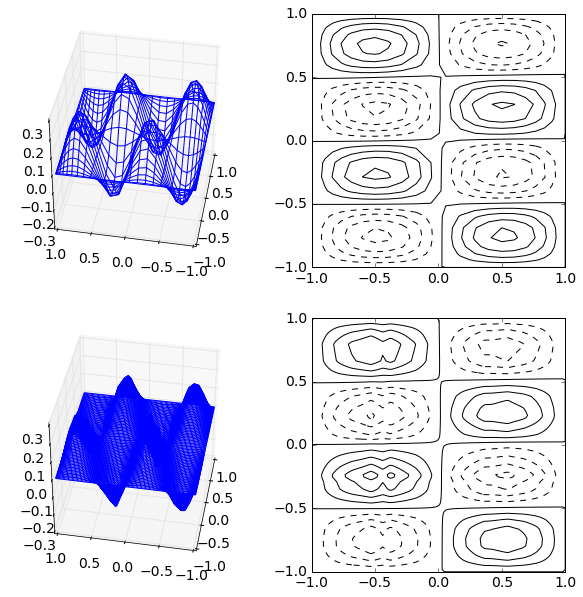

In [29]:
elev_widget = IntSlider(min=0, max=180, step=10, value=40)
azim_widget = IntSlider(min=0, max=360, step=10, value=230)

def example_6(N=10,elev=40,azim=230,k=9,n_contours=8):
    D,x = cheb(N)
    y=x
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    xx,yy=np.meshgrid(x[1:-1],y[1:-1])
    xx = xx.flatten()
    yy = yy.flatten()

    f = np.exp(-10.*((yy-1.)**2+(xx-.5)**2))

    I = np.eye(N-1)
    # The Laplacian
    L = np.kron(I,D2)+np.kron(D2,I)+k**2*np.eye((N-1)**2)

    u = np.linalg.solve(L,f)

    fig = plt.figure(figsize=(2*M,2*M))

    # Plotting the approximation and its interpolation

    # The numerical approximation
    uu = np.zeros((N+1,N+1))
    uu[1:-1,1:-1]=np.reshape(u,(N-1,N-1))
    xx,yy=np.meshgrid(x,y)
    value = uu[int(N/4),int(N/4)]

    plt.subplot(221,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xx, yy, uu)
    ax.view_init(elev,azim)

    plt.subplot(222)
    plt.contour(xx, yy, uu, n_contours,
                 colors='k',  # negative contours will be dashed by default
                 )
   
    # The INTERPOLATED approximation
    N_fine=4*N
    finer_mesh=np.linspace(-1,1,N_fine)
    xxx,yyy=np.meshgrid(finer_mesh,finer_mesh)
    uuu = spf.interpolate.interp2d(xx, yy, uu, kind='linear')
    uuu_n=np.reshape(uuu(finer_mesh,finer_mesh),(N_fine,N_fine))

    plt.subplot(223,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xxx, yyy, uuu_n)
    ax.view_init(elev,azim)
    
    plt.subplot(224)
    plt.contour(xxx, yyy, uuu_n, n_contours,
                 colors='k',  # negative contours will be dashed by default
                 )
    
    plt.show()
interact(example_6,N=(3,30),elev=elev_widget,azim=azim_widget,k=(1,20),n_contours=(5,12))

# Example 7:  (2D)  $-(u_{xx}+u_{yy})=\lambda\,u$ with u=0 on $\partial\Gamma$

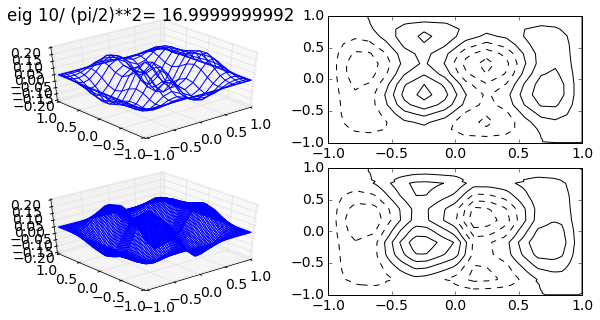

In [31]:
elev_widget = IntSlider(min=0, max=180, step=10, value=40)
azim_widget = IntSlider(min=0, max=360, step=10, value=230)
N_widget = IntSlider(min=2, max=30, step=1, value=10)
j_widget = IntSlider(min=1, max=20, step=1, value=1)

def update_j_range(*args):
    j_widget.max = (N_widget.value-1)**2
j_widget.observe(update_j_range, 'value')

def example_7(N=10,elev=40,azim=230,n_contours=8,j=1):
    D,x = cheb(N)
    y=x
    D2  = np.dot(D,D)
    D2  = D2[1:-1,1:-1]

    xx,yy=np.meshgrid(x[1:-1],y[1:-1])
    xx = xx.flatten()
    yy = yy.flatten()

    I = np.eye(N-1)
    # The Laplacian
    L = (np.kron(I,-D2)+np.kron(-D2,I))

    lam, V = np.linalg.eig(L)

    ii=np.argsort(np.real(lam))
    lam=lam[ii]
    V=V[:,ii]

    fig = plt.figure(figsize=(2*M,M))

    # Plotting the approximation and its interpolation

    # The numerical approximation
    vv = np.zeros((N+1,N+1))
    vv[1:-1,1:-1]=np.reshape(np.real(V[:,j-1]),(N-1,N-1))
    xx,yy=np.meshgrid(x,y)

    plt.subplot(221,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xx, yy, vv)
    plt.title('eig '+str(j)+'/ (pi/2)**2= '+str(lam[j-1]/((np.pi/2)**2)))
    ax.view_init(elev,azim)

    plt.subplot(222)
    plt.contour(xx, yy, vv, n_contours,
                 colors='k',  # negative contours will be dashed by default
                 )

    # The INTERPOLATED approximation
    N_fine=4*N
    finer_mesh=np.linspace(-1,1,N_fine)
    xxx,yyy=np.meshgrid(finer_mesh,finer_mesh)
    vvv = spf.interpolate.interp2d(xx, yy, vv, kind='linear')
    vvv_n=np.reshape(vvv(finer_mesh,finer_mesh),(N_fine,N_fine))

    plt.subplot(223,projection='3d')
    ax = fig.gca()
    #surf = ax.plot_surface(xxx, yyy, uuu_n, rstride=1, cstride=1, cmap=cm.coolwarm,
    #                       linewidth=0, antialiased=False)
    ax.plot_wireframe(xxx, yyy, vvv_n)
    ax.view_init(elev,azim)

    plt.subplot(224)
    plt.contour(xxx, yyy, vvv_n, n_contours,
                 colors='k',  # negative contours will be dashed by default
                 )

    plt.show()
interact(example_7,N=N_widget,elev=elev_widget,azim=azim_widget,n_contours=(5,12),j=j_widget)

# In-class work

## [Flash back] Implement Program 6, 7 and 12.

## [Today] Implement Program 19, 20, 21, 22 and 23.